# L7b: Evaluation of Bandit Problem Algorithms
In this lab, we'll continue our discussion [of multiarm bandit problems](https://en.wikipedia.org/wiki/Multi-armed_bandit) and look at the performance of the explore first, $\epsilon$-greedy and UCB1 algorithms on a simple stochastic bandit problem.

## Stochastic Multi-Armed Bandits
In the stochastic multi-armed bandit problem, an agent must choose an action $a$ from the set of all possible actions $\mathcal{A}$, where $\dim\mathcal{A} = K$ during each round $t = 1,2,\dots, T$ of a decision task. The agent chooses action $a\in\mathcal{A}$ and receives a reward $r_{a}$ from the environment, where $r_{a}$ is sampled from some (unknown) distribution $\mathcal{D}_{a}$.

For $t = 1,2,\dots,T$:
1. _Aggregator_: The agent picks an action $a_{t} \in \mathcal{A}$ at time time $t$. How the agent makes this choice is one of the main differences between the different algorithms for solving this problem. 
2. _Adversary_: The agent implements action $a_{t}$ and receives a (random) reward $r_{a}\sim\mathcal{D}_{a}$ where $r_{t}\in\left[0,1\right]$. The distribution $\mathcal{D}_{a}$ is only known to the adversary.
3. The agent updates its _memory_ with the reward and continues to the next decision task. 

The agent is interested in learning the mean of the reward distribution of each arm, $\mu(a) = \mathbb{E}\left[r_{t}\sim\mathcal{D}_{a}\right]$, by experimenting against the world (adversary). 
* __Goal__: The goal of the agent is to maximize the total reward. However, the goal of the algorithm designer is to minimize the _regret_ of the algorithm that the agent uses to choose $a\in\mathcal{A}$.

### Tasks
Before we start, divide into teams and familiarize yourself with the lab. Then, execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!
* __Task 1: Setup, Data, Prerequisites (10 min)__: Let's take 10 minutes to set up the problem and, in particular, to examine the properties of the `world(a)` function. The `world(a)` function takes an action $a\in\mathcal{A}$ and returns the reward $r_{a}\sim\mathcal{D}_{a}$.
* __Task 2: Evaluation of Algorithms (20 min)__: In this task, we'll implement and run the explore first, $\epsilon$-greedy, and the UCB1 algorithms on our example `K`-arm bandit problem.
* __Task 3: Compute the Empirical Regret for each Algorithm (10 min)__: In this task, we compute the empirical regret of each choice algorithm and see which algorithm gives the best actual performance and which was predicted to have the best theoretical performance.

## Task 1: Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 
* The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [3]:
include("Include.jl");

First, let's build the `world(...)` function. This function takes the action $a$ from our agent and returns the reward associated with choosing this action, i.e., $r\sim\mathcal{D}_{a}$. We'll use [a Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) to model the rewards.

A [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) has two parameters $\left(\alpha,\beta\right)$ which determine its share. The expectation of a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) is given by: $\alpha/(\alpha+\beta)$.

In [5]:
function world(a::Int64)::Float64

    # initialize -
    model = Dict{Int, Beta}();
    model[1] = Beta(2.0,2.0); # action 1
    model[2] = Beta(10.0,2.0); # action 2
    model[3] = Beta(2.0,10.0); # action 3
    model[4] = Beta(6.0,20.0); # action 4
    model[5] = Beta(20.0,6.0); # action 5
    model[6] = Beta(20.0,10.0); # action 6
    model[7] = Beta(10.0,20.0); # action 7

    # return -
    return model[a] |> d-> rand(d);
end;

`Unhide` the code block below to see how we plotted a sample [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) for different choices of the $(\alpha,\beta)$ parameters of the distribution.

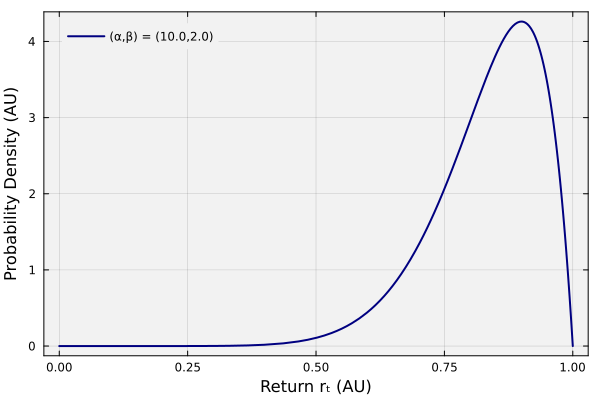

In [7]:
let
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); 
    α,β = 10.0, 2.0;
    d = Beta(α,β);
    plot!(d, lw=2, c=:navy, label="(α,β) = ($(α),$(β))")
    xlabel!("Return rₜ (AU)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

### Constants
Finally, let's set some constants we'll use in the subsequent tasks. See the comment beside the value for a description of what it is, its permissible values, etc.

In [9]:
K = 7; # number of arms for the bandit
T = 5000; # number of rounds for each decision task

## Task 2: Evaluation of Algorithms
In this task, we'll implement and run the explore first, $\epsilon$-greedy, and the UCB1 algorithms on our example `K`-arm bandit problem. We'll explain each algorithm and look at its outputs.

Let's start with the explore first algorithm.

### Explore First Algorithm
The agent has $K$ arms, $\mathcal{A} = \left\{1,2,\dots,K\right\}$, and the total number of rounds is $T$. The agent uses the following algorithm to choose which arm to pull during each round:
1. _Initialization_: For each arm $a\in\mathcal{A}$, set $N_{a} = (T/K)^{2/3}\cdot\mathcal{O}\left(\log{T}\right)^{1/3}$ (the number of times we try action $a$).
2. _Exploration_: Play each arm $a\in\mathcal{A}$ for $N_{a}$ rounds and record the rewards. After the exploration phase, select the arm $a^{\star}$ with the highest mean reward (break ties arbitrarily).
3. _Explotation_: Play arm $a^{\star}$ for the remaining rounds.

__Theorem__: The _expected_ regret over $T$ rounds of the _uniform exploration_ algorithm is bounded by $\mathbb{E}\left[R(T)\right]\leq{T}^{2/3}\times\mathcal{O}\left(K\cdot\log{T}\right)^{1/3}$, where $K$ is the number of arms, $T$ is the total number of rounds and $N = (T/K)^{2/3}\cdot\mathcal{O}\left(\log{T}\right)^{1/3}$ is the number of rounds in the exploration phase for each action (choice).

#### Implementation
We've created a custom type for each algorithm with information about the algorithm or problem. In this implementation, we are only storing the number of arms. We then pass that model to a solve method that runs the task.

We create an [instance of the `MyExploreFirstAlgorithmModel` type](src/Types.jl) which holds the number of arms `K` using [a `build(...)` method](src/Factory.jl). To solve the problem, we pass the model [to the `solve(...)` method](src/Bandit.jl), which returns the output from the game.
* __Output__: Each of [the `solve(...)` methods](src/Bandit.jl) returns a results array $\mathbf{U}$ holding the records of the game. The rows of the array are the turns of the decision task, while each column corresponds to the action $a\in\mathcal{A}$. If $u_{t,a}>0$, then action $a$ was chosen in round $t$, and $u_{t,a}$ is the reward received for taking action $a$.

In [12]:
results_explore_first = let

    m = build(MyExploreFirstAlgorithmModel, (
        K = K, # number of arms
    ));
    
    results = solve(m, T = T, world = world);
    results;
end

5000×7 Matrix{Float64}:
 0.851038   0.0       0.0  0.0  0.0  0.0  0.0
 0.562632   0.0       0.0  0.0  0.0  0.0  0.0
 0.770096   0.0       0.0  0.0  0.0  0.0  0.0
 0.0362062  0.0       0.0  0.0  0.0  0.0  0.0
 0.919817   0.0       0.0  0.0  0.0  0.0  0.0
 0.730046   0.0       0.0  0.0  0.0  0.0  0.0
 0.378114   0.0       0.0  0.0  0.0  0.0  0.0
 0.29857    0.0       0.0  0.0  0.0  0.0  0.0
 0.761465   0.0       0.0  0.0  0.0  0.0  0.0
 0.275114   0.0       0.0  0.0  0.0  0.0  0.0
 0.367893   0.0       0.0  0.0  0.0  0.0  0.0
 0.669713   0.0       0.0  0.0  0.0  0.0  0.0
 0.105514   0.0       0.0  0.0  0.0  0.0  0.0
 ⋮                                   ⋮    
 0.0        0.900373  0.0  0.0  0.0  0.0  0.0
 0.0        0.842964  0.0  0.0  0.0  0.0  0.0
 0.0        0.897511  0.0  0.0  0.0  0.0  0.0
 0.0        0.899306  0.0  0.0  0.0  0.0  0.0
 0.0        0.680153  0.0  0.0  0.0  0.0  0.0
 0.0        0.682061  0.0  0.0  0.0  0.0  0.0
 0.0        0.850849  0.0  0.0  0.0  0.0  0.0
 0.0        0

#### What action was chosen?
From the results array $\mathbf{U}$, we can see what action was chosen during each round $t$ by looking at the row $t$ of the results array. The action at $t$ is $a=\text{arg}\max\left\{u_{t,1},u_{t,2},\dots,u_{t,K}\right\}$.

In [14]:
argmax(results_explore_first[28,:])

1

In [15]:
Nₐ = ((T/K)^(2/3))*(log(T))^(1/3) |> x -> round(Int,x) # number of explore steps

163

### Epsilon-Greedy Algorithm
The agent has $K$ arms (choices), $\mathcal{A} = \left\{1,2,\dots,K\right\}$, and the total number of rounds is $T$. The agent uses the following algorithm to choose which arm to pull (which action to take) during each round:

For $t = 1,2,\dots,T$:
1. _Initialize_: Roll a random number $p\in\left[0,1\right]$ and compute a threshold $\epsilon_{t}\sim{t}^{-1/3}$. Note, in other sources, $\epsilon$ is a constant, not a function of $t$.
2. _Exploration_: If $p\leq\epsilon_{t}$, choose a random (uniform) arm $a_{t}\in\mathcal{A}$. Execute the action $a_{t}$ and receive a reward $r_{t}$ from the _adversary_ (nature). 
3. _Exploitation_: Else if $p>\epsilon_{t}$, choose action $a^{\star}$ (action with the highest average reward so far, the greedy choice). Execute the action $a^{\star}_{t}$ and recieve a reward $r_{t}$ from the _adversary_ (nature).
4. Update list of rewards for $a_{t}\in\mathcal{A}$

__Theorem__: The epsilon-greedy algowithm with exploration probability $\epsilon_{t}={t^{-1/3}}\cdot\left(K\cdot\log(t)\right)^{1/3}$ achives a regret bound of $\mathbb{E}\left[R(t)\right]\leq{t}^{2/3}\cdot\left(K\cdot\log(t)\right)^{1/3}$ for each round $t$.

#### Implementation
We've created a custom type for each algorithm with information about the algorithm or problem. In this implementation, we are only storing the number of arms. We then pass that model to a solve method that runs the task.

We create an [instance of the `MyEpsilonGreedyAlgorithmModel` type](src/Types.jl) which holds the number of arms `K` using [a `build(...)` method](src/Factory.jl). To solve the problem, we pass the model [to the `solve(...)` method](src/Bandit.jl), which returns the output from the game.
* __Output__: Each of [the `solve(...)` methods](src/Bandit.jl) returns a results array $\mathbf{U}$ holding the records of the game. The rows of the array are the turns of the decision task, while each column corresponds to the action $a\in\mathcal{A}$. If $u_{t,a}>0$, then action $a$ was chosen in round $t$, and $u_{t,a}$ is the reward received for taking action $a$.

In [17]:
results_eps_greedy = let

    m = build(MyEpsilonGreedyAlgorithmModel, (
        K = K, # number of arms
    ));
    
    results = solve(m, T = T, world = world);
    results;
end

5000×7 Matrix{Float64}:
 0.0       0.0       0.0       0.129626  0.0       0.0       0.0
 0.0       0.0       0.24923   0.0       0.0       0.0       0.0
 0.0       0.818877  0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0       0.0       0.366927
 0.0       0.0       0.187626  0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.176536  0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.829094  0.0       0.0
 0.0       0.933906  0.0       0.0       0.0       0.0       0.0
 0.475401  0.0       0.0       0.0       0.0       0.0       0.0
 0.850198  0.0       0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0       0.752111  0.0
 0.0       0.958242  0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.713379  0.0       0.0
 ⋮                                                 ⋮         
 0.0       0.844678  0.0       0.0       0.0       0.0       0.0

### UCB1 Algorithm
The agent has $K$ arms (choices), $\mathcal{A} = \left\{1,2,\dots,K\right\}$, and a total number of rounds is $T\gg{K}$.

_Initialization_: Pull each arm $a\in\mathcal{A}$ once and record the rewards. For each arm $a\in\mathcal{A}$, set $N_{a} = 1$ and $\bar{\mu}(a) = r_{a}$.

For rounds $t = K+1,K+2,\dots,T$:
1. Compute the upper confidence bound $U(a,t)$ for each arm $a\in\mathcal{A}$ where $U(a,t) = \sqrt{\frac{2\log(t)}{N_{a}}}$.
2. Choose the best arm $a^{\star} = \text{arg}\max\,\left\{\bar{\mu}(a)+U(a,t)\mid\,a\in\mathcal{A}\right\}$ at time $t$.
3. Execute the action $a^{\star}$ and recieve a reward $r_{t}$ from the _adversary_ (nature).
4. Update the estimated mean reward $\bar{\mu}(a^{\star})$ and the number of pulls $N_{a^{\star}}$

__Theorem__: The `UCB1` algorithm achieves a regret bound for $K$ arms of $\mathbb{E}\left[R(t)\right]\leq\mathcal{O}\left(\sqrt{KT\cdot\log(T)}\right)$ 
over $T$ rounds.

#### Implementation
We've created a custom type for each algorithm with information about the algorithm or problem. In this implementation, we are only storing the number of arms. We then pass that model to a solve method that runs the task.

We create an [instance of the `MyUCB1AlgorithmModel` type](src/Types.jl) which holds the number of arms `K` using [a `build(...)` method](src/Factory.jl). To solve the problem, we pass the model [to the `solve(...)` method](src/Bandit.jl), which returns the output from the game.
* __Output__: Each of [the `solve(...)` methods](src/Bandit.jl) returns a results array $\mathbf{U}$ holding the records of the game. The rows of the array are the turns of the decision task, while each column corresponds to the action $a\in\mathcal{A}$. If $u_{t,a}>0$, then action $a$ was chosen in round $t$, and $u_{t,a}$ is the reward received for taking action $a$.

In [19]:
results_UCB1 = let

    m = build(MyUCB1AlgorithmModel, (
        K = K,
    ));

    results = solve(m, T = T, world = world);
    results;
end

5000×7 Matrix{Float64}:
 0.521813  0.0       0.0       0.0       0.0       0.0       0.0
 0.0       0.842762  0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.215358  0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.181252  0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.837392  0.0       0.0
 0.0       0.0       0.0       0.0       0.0       0.724563  0.0
 0.0       0.0       0.0       0.0       0.0       0.0       0.2288
 0.0       0.827057  0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.787426  0.0       0.0
 0.0       0.0       0.0       0.0       0.0       0.540829  0.0
 0.481746  0.0       0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.0       0.0       0.361386
 0.0       0.0       0.117113  0.0       0.0       0.0       0.0
 ⋮                                                 ⋮         
 0.0       0.87237   0.0       0.0       0.0       0.0       

## Task 3: Compute the Empirical Regret for each Algorithm
In this task, we compute the empirical regret of each choice algorithm and see which algorithm gives the best actual performance and which was predicted to have the best theoretical performance.

__Regret__: Let $\mu^{\star}$ be the mean of the best arm, i.e., $\mu^{\star} = \max_{a\in\mathcal{A}}\mu(a)$ after playing the game for $T$ rounds. The regret $R(T)$ of an algorithm after $T$ rounds is defined as:
$$
\begin{align*}
R(T) = T\cdot\mu^{\star} - \sum_{t=1}^{T}\mu(a_{t})
\end{align*}
$$
The first term is the reward that would have been obtained if the best arm was always chosen over the $T$ rounds. The second term is the mean reward obtained by the agent over the $T$ rounds, where $a_{t}$ is the action chosen by the agent at round $t$.

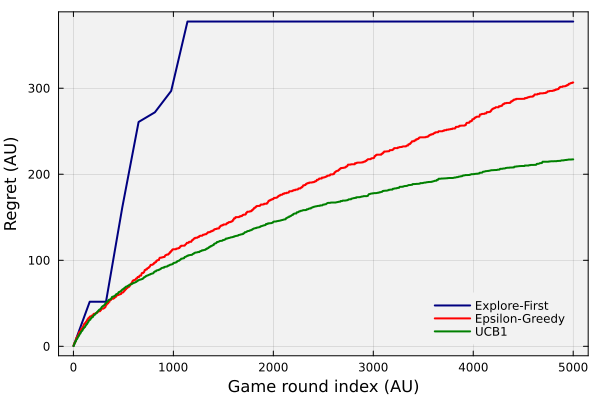

In [21]:
let

    # compute the regret
    R₁ = regret(results_explore_first);
    R₂ = regret(results_eps_greedy);
    R₃ = regret(results_UCB1);

    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    plot!(R₁, lw=2, label="Explore-First", c=:navy)
    plot!(R₂, lw=2, label="Epsilon-Greedy", c=:red)
    plot!(R₃, lw=2, label="UCB1", c=:green)
    xlabel!("Game round index (AU)", fontsize=18)
    ylabel!("Regret (AU)", fontsize=18)

end

### Theoretical regret bound
Finally, let's compute the theoretical regret bound for the algorithms we explored. Let's start with the explore-first algorithm.

__Explore-First__: The _expected_ regret over $T$ rounds of the _uniform exploration_ algorithm is bounded by $\mathbb{E}\left[R(T)\right]\leq{T}^{2/3}\times\mathcal{O}\left(K\cdot\log{T}\right)^{1/3}$, where $K$ is the number of arms, $T$ is the total number of rounds

In [37]:
(T^(2/3))*(K*log(T))^(1/3)

1142.2947540395082

__Epsilon-Greedy__: The epsilon-greedy algowithm with exploration probability $\epsilon_{t}={t^{-1/3}}\cdot\left(K\cdot\log(t)\right)^{1/3}$ achives a regret bound of $\mathbb{E}\left[R(t)\right]\leq{t}^{2/3}\cdot\left(K\cdot\log(t)\right)^{1/3}$ for each round $t$. Let's look at the _average_ regret:

In [63]:
regret_eps_greedy = let

    t = 1000;
    regret = (T/t)*(t^(2/3))*(K*log(t))^(1/3)
end

1821.580347464354

__UCB1__: The `UCB1` algorithm achieves a regret bound for $K$ arms of $\mathbb{E}\left[R(t)\right]\leq\mathcal{O}\left(\sqrt{KT\cdot\log(T)}\right)$ 
over $T$ rounds.

In [44]:
sqrt(K*T*log(T))

545.9869611076517